In [ ]:
# %pip install -Uq "unstructured[all-docs]" pillow lxml pillow
# %pip install -Uq chromadb tiktoken
# %pip install -Uq langchain langchain-community langchain-openai langchain-groq
# %pip install -Uq python_dotenv

In [25]:
import os

os.environ["OPENAI_API_KEY"] = ""

os.environ["GROQ_API_KEY"] = ""
# os.environ["LANGCHAIN_API_KEY"] = "sk-..."
# os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [28]:
from unstructured.partition.pdf import partition_pdf

# output_path = "./content/"
# file_path = output_path + 'attention.pdf'
file_path="data/Lecture-Notes-Mid1.pdf"

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name


In [ ]:
# import nltk
# nltk.download('averaged_perceptron_tagger')


In [ ]:
# !pip install --upgrade certifi


In [ ]:
# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass  # For older versions of Python that don't verify HTTPS certificates by default
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download('averaged_perceptron_tagger')


In [29]:
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>",
 "<class 'unstructured.documents.elements.Table'>"}

In [6]:
chunks[11].metadata.orig_elements

In [7]:
elements = chunks[11].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '7d525a95-a243-4018-b296-5e65c5af5016',
 'text': "It Pays This Plus This Percentage Average Tax If a Corporation's Amount onthe onthe Excessoverthe Rate at Top of Taxable Income Is Base of the Bracket Base (Marginal Rate) Bracket Up to $50,000 $ 0 15% 15.0% $50,000-$75,000 7,500 25 18.3 $75,000-$100,000 13,750 34 22.3 $100,000-$335,000 22,250 39 34.0 $335,000-$ 10,000,000 113,900 34 34.0 $10,000,000-$ 15,000,000 3,400,000 35 34.3 $15,000,000-$18,333,333 5,150,000 38 35.0 Over $18,333,333 6,416,667 35 35.0 1 On December 26, 2007, President Bush signed legislation that (1) increases the AMT exemption amounts for 2007 to $44,350 for single taxpayers and $66,250 for joint filers and (2) allows taxpayers to take several tax credits for AMT purposes through 2007.",
 'metadata': {'coordinates': {'points': ((250.0, 1004.9444444444443),
    (250.0, 1650.7777777777776),
    (1497.9166666666665, 1650.7777777777776),
    (1497.9166666666665, 1004.9444444444443)),
 

In [30]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [31]:
tables

In [32]:
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

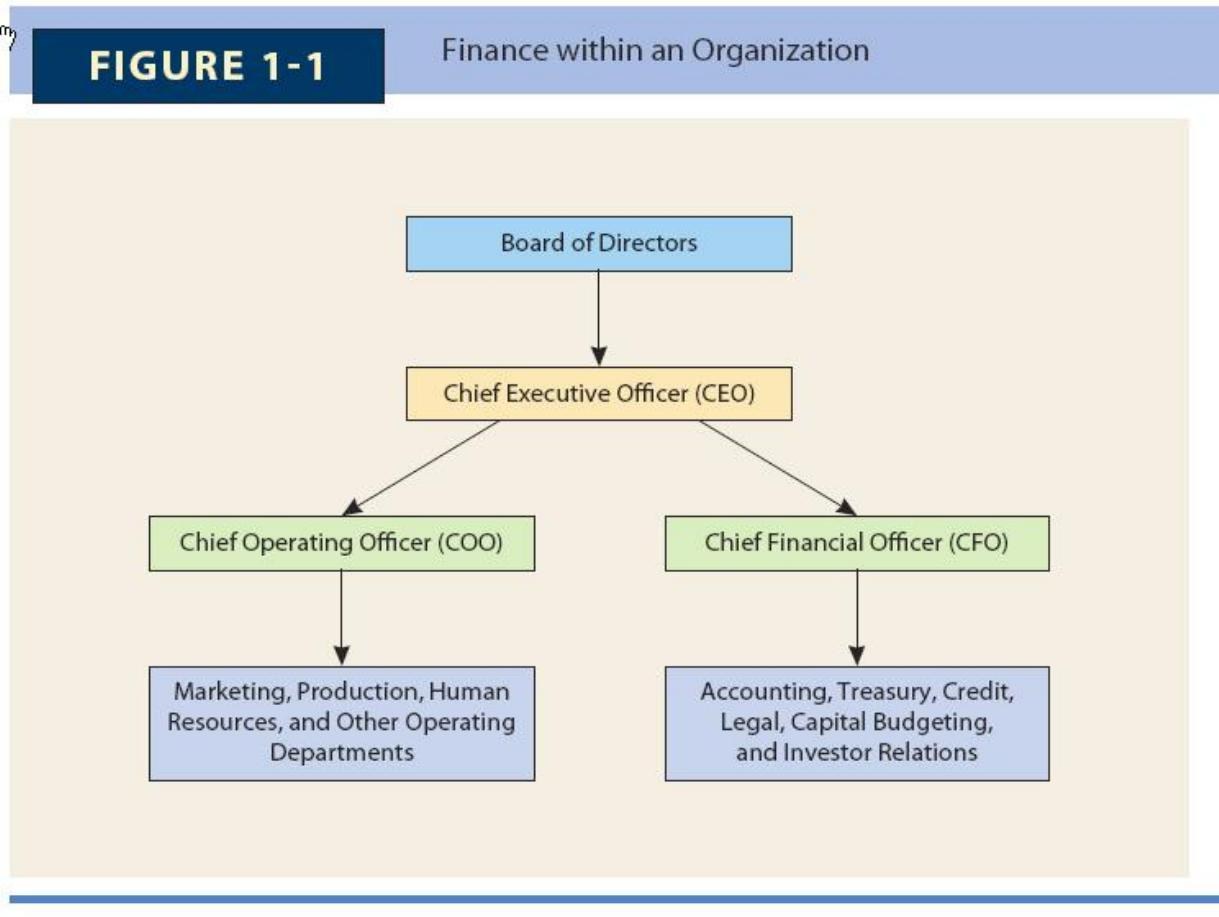

In [33]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[1])

## Text and table summaries

In [34]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [35]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [36]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [37]:
text_summaries

["Finance is the study of cash flows between capital markets and a firm's operations, aiming to maximize shareholder wealth through financing, investment, and dividend decisions. \n\nKey concepts include intrinsic value, market price, and stock equilibrium, with intrinsic value being an estimate of a stock's fair value and market price determined by demand and supply. \n\nA firm's goal is to maximize shareholder wealth, rather than profit or earnings per share (EPS) maximization, due to timing and risk considerations. \n\nForms of business organization include proprietorship, partnership, corporation, S corporation, and limited liability company (LLC), each with its advantages and disadvantages. \n\nImportant business trends include globalization, improving information technology, and corporate governance. \n\nBusiness ethics involve standards of conduct toward employees, customers, community, and stockholders, while the agency problem arises from a potential conflict of interest betwe

In [38]:
table_summaries

['List of securities.',
 'Table listing business and intermediary securities, with empty columns for unknown or unspecified information.',
 'The stock price increased by 0.64% to 38.86, opening at 39.30 with a change of 0.25.',
 'The table compares average returns and standard deviations of different investment types: Small-stocks (17.1% return, 32.6% standard deviation), Large-stocks (12.3% return, 20.0% standard deviation), Long-term corporate bonds (6.2% return, 8.4% standard deviation), Long-term government bonds (5.8% return, 9.2% standard deviation) and US Treasury bills (3.8% return, 3.1% standard deviation).',
 "A company's balance sheet is composed of current assets, current liabilities, net fixed assets, long-term debt, other assets, and common equity, categorized into short-term and long-term components.",
 'The table outlines corporate tax rates in the US, with a top rate of 35.0% for taxable income over $18,333,333. The tax rates increase in steps, with marginal rates of 1

## Image summaries

In [15]:
from dotenv import load_dotenv

# logging.basicConfig(level=logging.DEBUG)

# Load environment variables
# load_dotenv()

# BASE_URL = os.getenv("AZURE_BASE_URL")
# BASE_URL = "https://hcmp-aiml-oai.openai.azure.com"
# OPEN_API_KEY = os.getenv("AZURE_OPEN_API_KEY")
# OPENAI_API_VERSION="2024-08-01-preview"
# AZURE_DEPLOYMENT_NAME="hcmp-aiml-oai-gpt4o-mini"

In [ ]:
# from langchain_openai import ChatOpenAI
# # from langchain_community.chat_models import AzureChatOpenAI

# prompt_template = """Describe the image in detail. For context,
#                   the image is part of a research paper explaining the transformers
#                   architecture. Be specific about graphs, such as bar plots."""
# messages = [
#     (
#         "user",
#         [
#             {"type": "text", "text": prompt_template},
#             {
#                 "type": "image_url",
#                 "image_url": {"url": "data:image/jpeg;base64,{image}"},
#             },
#         ],
#     )
# ]

# # llm = AzureChatOpenAI(
# #     azure_endpoint=BASE_URL.rstrip('/'),  # Ensure no trailing slash
# #     # deployment_name=selected_model["deployment_name"],
# #     deployment_name="hcmp-aiml-oai-gpt4o-mini",  # Use selected model's deployment name
# #     # openai_api_version="2023-03-15-preview",
# #     api_version="2024-08-01-preview",
# #     api_key=OPEN_API_KEY,
# #     openai_api_type="Azure",
# #     temperature=0
# # )





# prompt = ChatPromptTemplate.from_messages(messages)

# # chain = prompt | AzureChatOpenAI(model=llm) | StrOutputParser()
# chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


# import time
# from langchain_core.runnables import RunnableSequence

# def run_with_retries(chain, inputs, max_retries=3):
#     for attempt in range(max_retries):
#         try:
#             return chain.batch(inputs)
#         except RateLimitError as e:
#             print(f"Rate limit reached, retrying in {2 ** attempt} seconds...")
#             time.sleep(2 ** attempt)  # Exponential backoff
#     raise Exception("Max retries reached")

# # Example usage
# image_summaries = run_with_retries(chain, images)

# # chain = prompt | llm | StrOutputParser()


# # image_summaries = chain.batch(images)

In [ ]:
# import uuid
# import time
# from langchain_openai import ChatOpenAI
# from langchain_core.runnables import RunnableSequence
# from langchain_core.runnables.exceptions import RateLimitError  # Import RateLimitError

# # Define your prompt template
# prompt_template = """Describe the image in detail. For context,
#                   the image is part of a research paper explaining the transformers
#                   architecture. Be specific about graphs, such as bar plots."""

# # Create messages for the model
# def create_messages(image):
#     return [
#         (
#             "user",
#             [
#                 {"type": "text", "text": prompt_template},
#                 {
#                     "type": "image_url",
#                     "image_url": {"url": f"data:image/jpeg;base64,{image}"},
#                 },
#             ],
#         )
#     ]


# # Initialize your ChatOpenAI model
# llm = ChatOpenAI(model="gpt-4o-mini")
# batch_size = 2  # Set your desired batch size

# # Function to process images in batches
# def process_images_in_batches(images, batch_size):
#     results = []
#     for i in range(0, len(images), batch_size):
#         batch = images[i:i + batch_size]
#         messages_batch = [create_messages(image) for image in batch]

#         # Process the batch with retry logic
#         for attempt in range(3):  # Retry logic for each batch
#             try:
#                 image_summaries = llm.batch(messages_batch)  # Call the model with the batch
#                 results.extend(image_summaries)  # Store the results
#                 break  # Exit the retry loop if successful
#             except RateLimitError as e:
#                 print(f"Rate limit reached for batch {i // batch_size + 1}, retrying in {2 ** attempt} seconds...")
#                 time.sleep(2 ** attempt)  # Exponential backoff
#                 if attempt == 2:  # If max retries reached
#                     print("Max retries reached for this batch. Moving to next batch.")
#     return results

# # Call the process_images_in_batches function
# image_summaries = process_images_in_batches(images, batch_size)

In [ ]:
# import time
# from langchain_openai import ChatOpenAI

# # Define the prompt template
# prompt_template = """Describe the image in detail. For context,
#                   the image is part of a research paper explaining the transformers
#                   architecture. Be specific about graphs, such as bar plots."""

# # Create messages for the model
# def create_messages(image):
#     return [
#         (
#             "user",
#             [
#                 {"type": "text", "text": prompt_template},
#                 {
#                     "type": "image_url",
#                     "image_url": {"url": f"data:image/jpeg;base64,{image}"},
#                 },
#             ],
#         )
#     ]

# # Initialize your ChatOpenAI model
# llm = ChatOpenAI(model="gpt-4o-mini")

# # Function to process images with a sleep interval
# def process_images(images):
#     results = []
#     for image in images:
#         messages = create_messages(image)
#         attempt = 0
#         while attempt < 3:  # Retry up to 3 times
#             try:
#                 summary = llm(messages)  # Call the model with the messages
#                 results.append(summary)
#                 break  # If successful, exit the retry loop
#             except Exception as e:  # Catch all exceptions
#                 print(f"Error occurred: {e}")
#                 attempt += 1
#                 if attempt < 3:
#                     print("Sleeping for 5 seconds before retrying...")
#                     time.sleep(5)  # Sleep for 5 seconds before retrying
#                 else:
#                     print("Max retries reached for this image.")

#         time.sleep(5)  # Sleep for 1 second between each request to avoid hitting the rate limit too quickly

#     return results

# # Call the process_images function
# image_summaries = process_images(images)

In [16]:
from langchain_openai import ChatOpenAI
import os

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

In [17]:
image_summaries

["The image depicts a flowchart illustrating the interaction between different components in a financial system, specifically focusing on a firm's operations and the role of financial managers.\n\n### Components:\n1. **Firm's Operation (Real Assets)**: This is represented as a rectangular box on the left side of the diagram. It symbolizes the tangible aspects of a firm's activities, such as its physical assets and operations.\n\n2. **Financial Managers**: In the center, another rectangular box signifies the financial managers. This element is crucial as it acts as a mediator between the firm's operations and the capital markets.\n\n3. **Capital Markets (Financial Assets)**: This box is positioned on the right side, representing the financial environment where assets are traded, including stocks, bonds, and other financial instruments.\n\n### Arrows and Labels:\n- **Arrows**: The arrows indicate the flow of information or resources between the components. \n  - From the **Firm's Operati

In [18]:
print(image_summaries[1])

The image appears to be a flowchart illustrating the organizational structure of finance within a company. 

1. **Title**: The top of the image features the title "FIGURE 1-1 Finance within an Organization," set against a light blue background.

2. **Board of Directors**: At the top of the chart, there is a blue rectangular box labeled "Board of Directors." This signifies the highest level of governance in the organization.

3. **Chief Executive Officer (CEO)**: Below the Board of Directors, there is a yellow rectangular box labeled "Chief Executive Officer (CEO)," which indicates the primary executive responsible for managing the organization.

4. **Chief Operating Officer (COO)**: To the left of the CEO, a green box labeled "Chief Operating Officer (COO)" branches off, indicating that the COO reports directly to the CEO.

5. **Chief Financial Officer (CFO)**: To the right of the CEO, there is a green box labeled "Chief Financial Officer (CFO)," also indicating direct reporting to the

## Load data and summaries to vectorstore

### Creating the vectorestore

In [19]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
persist_directory = "./db"
vectorstore = Chroma(persist_directory=persist_directory, collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

/var/folders/3d/bdnj3mfd4b7gjd43nrjsnjqwdndpp4/T/ipykernel_33430/954826853.py:10: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  vectorstore = Chroma(persist_directory=persist_directory, collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())
/var/folders/3d/bdnj3mfd4b7gjd43nrjsnjqwdndpp4/T/ipykernel_33430/954826853.py:10: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vect

In [20]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

In [21]:
docs = retriever.invoke(
    "what is agency problem?"
)

In [22]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

Chapter 1 -- An Overview of Financial Management

What is finance: cash flows between capital markets and firm’s operations The goal of a firm Forms of business organization Business ethics Agency problem Career opportunities in finance

Intrinsic value and market price of a stock Important business trends

What is finance: cash flows between capital markets and firm’s operations

             (2)                     (1)      Firm’s  Operation                                        Financial     Managers                   (4a)         Capital  Markets            (Financial                      (3)                    (4b)      Assets)  

(Real Assets)

(1) Cash raised by selling financial assets in financial markets (2) Cash invested in firm’s operations and used to purchase real assets (3) Cash generated from firm’s operations (4a) Cash reinvested in firms’ operations (4b) Cash returned to investors

Financing decisions vs. investment decisions: raising money vs. allocating money Activ

In [23]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [24]:
response = chain.invoke(
    "how to analyse financial statements?"
)

print(response)

To analyze financial statements, one can use various financial ratios and metrics to assess a company's performance and financial health. Here are some key approaches:

1. **Profitability Ratios**: These ratios indicate how well a company is generating profit relative to its sales, assets, or equity. Key profitability ratios include:
   - Operating Profit Margin = EBIT / Sales
   - Profit Margin = Net Income / Sales
   - Return on Assets (ROA) = Net Income / Total Assets
   - Return on Equity (ROE) = Net Income / Common Equity

2. **Liquidity Ratios**: These ratios measure a company's ability to meet its short-term obligations. Common liquidity ratios include:
   - Current Ratio = Current Assets / Current Liabilities
   - Quick Ratio = (Current Assets - Inventories) / Current Liabilities

3. **Leverage Ratios**: These ratios assess the extent to which a company is using debt to finance its operations. Important leverage ratios include:
   - Debt Ratio = Total Debt / Total Assets
   - T

In [40]:
x="1"+"2"
print(x)

12
